### Можно посмотреть на датасет под еще одним углом - оценить положение лиц на картинках

In [1]:
import math

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '../input/made-cv-2021-contest-01-facial-landmarks/contest01_data/train'

In [3]:
def show_image(image_name, keypoints, title, rad=1, ax=None):
    src = cv2.imread(f'{DATA_PATH}/images/{image_name}')
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    for i, (x, y) in enumerate(keypoints):
        cv2.circle(src, (int(x), int(y)), rad, (0, 255, 0), -1)
    ax = ax or plt.gca()
    ax.set_title(title)
    ax.imshow(src)

Заметим, что позу (анфас\профиль и т.п.) можно оценить как отношение расстояний от любых крайних левыx\правых точек, до центральных.

Я для примера возьму отношение расстояний от левого\правого уха до подбородка:

In [4]:
def pose(points):
    chin = points[0]
    left_ear = points[120]
    right_ear = points[272]
    if chin[1] < left_ear[1] and chin[1] < right_ear[1]:
        return 10000
    return np.linalg.norm(left_ear - chin) / np.linalg.norm(right_ear - chin)

А наклон головы можно оценить как угол наклона прямой, проведенной через любый симметричные точки к оси X:

In [5]:
def rotation(points):
    left_ear = points[120]
    right_ear = points[272]
    m = left_ear - right_ear
    return math.degrees(math.atan2(*m[::-1]))

Загрузим данные:

In [6]:
data = {
    line.strip().split('\t')[0]: np.array(list(map(int, line.strip().split('\t')[1:]))).reshape(-1, 2) 
    for i, line in enumerate(open(f'{DATA_PATH}/landmarks.csv')) if i > 0
}

Оценим:

In [7]:
stats = pd.DataFrame.from_dict({
    'file': list(data.keys()), 
    'pose': list(map(pose, data.values())), 
    'rotation': list(map(rotation, data.values()))
})

In [8]:
full_face = stats[(stats.pose > .99) & (stats.pose < 1.1) & (stats.rotation == 0)].file.values[0]
left_profile = stats[(stats.pose > 1.50) & (stats.rotation == 0)].file.values[0]
right_profile = stats[(stats.pose < .60) & (stats.rotation == 0)].file.values[0]
rotated = stats[(stats.pose > .99) & (stats.pose < 1.1) & (stats.rotation < -30)].file.values[0]

Посмотрим примеры:

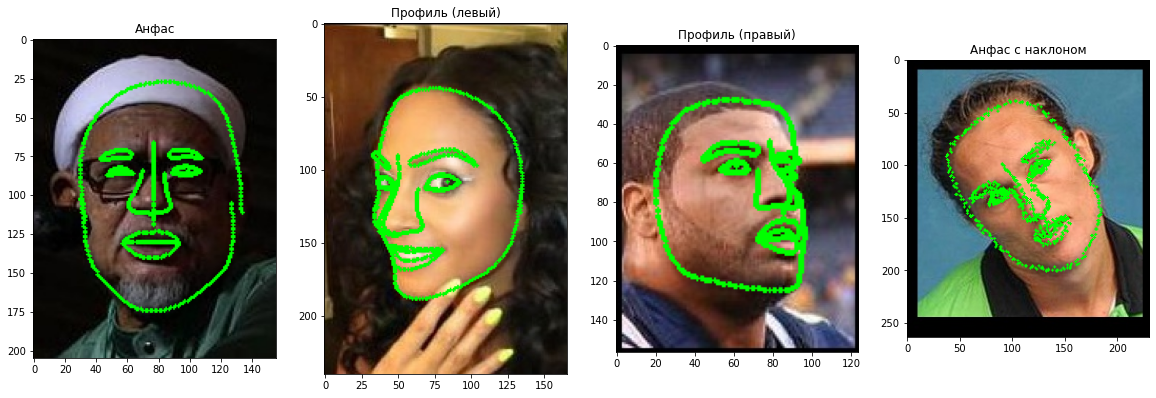

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20,10))

show_image(full_face, data[full_face], title='Анфас', rad=1, ax=axes[0])
show_image(left_profile, data[left_profile], title='Профиль (левый)', rad=1, ax=axes[1])
show_image(right_profile, data[right_profile], title='Профиль (правый)', rad=1, ax=axes[2])
show_image(rotated, data[rotated], title='Анфас с наклоном', rad=1, ax=axes[3])

Оценим распределение картинок в датасете в разрезе этих параметров:

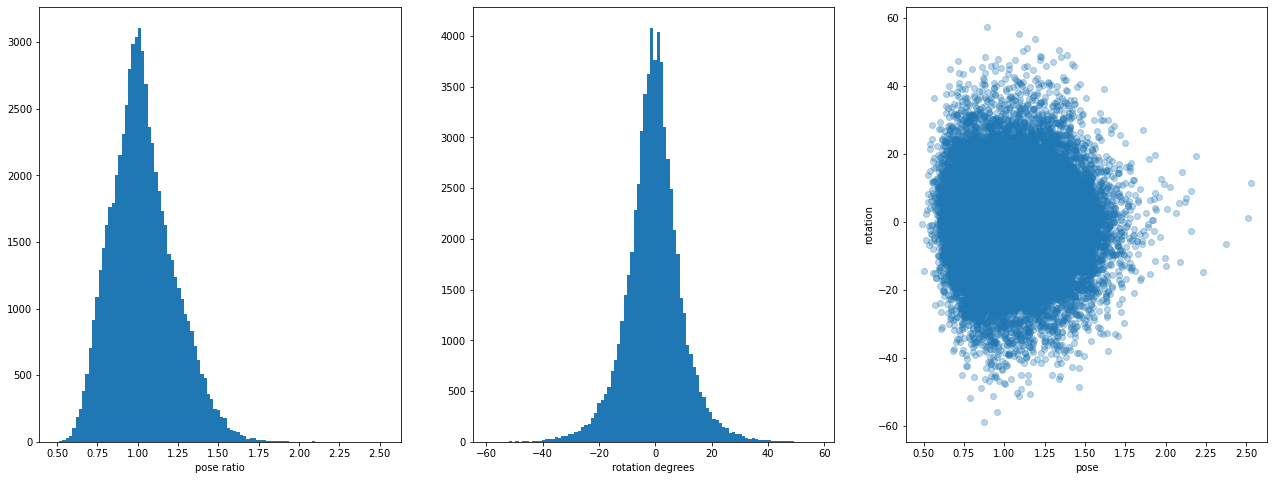

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(22,8))

axes[0].hist(stats['pose'].values, bins=100)
axes[0].set_xlabel('pose ratio')
axes[1].hist(stats['rotation'].values, bins=100)
axes[1].set_xlabel('rotation degrees')
axes[2].scatter(stats['pose'].values, stats['rotation'].values, alpha=0.3)
axes[2].set_xlabel('pose')
axes[2].set_ylabel('rotation')

plt.show()